# Poission eqn

- Sheet 1 Question 4:
    - 1) Two equivalent implementations of the FEM
    - 2) Exploring $\{ h, p \}$ pairs
- Sheet 1 Question 5: 
    - 3) Comments on the code
- Sheet 1 Question 6: 
    - 4) Different f(x,y)


by Adrian Bartko

### 1. Two equivalent implementations of the FEM

Below code:
- implements explicitly weak formulations u_1
- applies variation principle to find weak  formulation and then solves it u_2
- Creates contour plots
    - u_1, u_2, u_exact, u_1 - u_2, u_1 - u_exact

In [1]:
#
# Solution by Firedrake FEM-CG of a Poisson equatiom
#

import matplotlib.pyplot as plt
import numpy as np
from firedrake import *

nx = ny = 32 # Try various mesh resolutions, starting coarse, say 16x16 etc.

mesh = UnitSquareMesh(nx,ny,quadrilateral=True)
# Quadrilateral regular mesh made: https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.UnitSquareMesh
# Alternatively use gmsh: 

V = FunctionSpace(mesh, 'CG', 1) # Piecewise linear continuous Galerkin function space or polynomials
# See: https://www.firedrakeproject.org/variational-problems.html

#
# Method 1: construct the weak form manually by multiplying and manipulating the Poisson equation and solve the linear system
#
u = TrialFunction(V) # The unknown or variable u(x,y)
v = TestFunction(V)  # The testfunction of u, which may be better called delu or deltau

x, y = SpatialCoordinate(mesh) # Mesh coordinates

f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y)) # The given function f(x,y)

a = (inner(grad(u),grad(v)))*dx # Step 2/3: The weak form first term
L = (f*v)*dx # Step 2/3: The weak form second term; dx is the infinitesimal piece in the damain here: dx*dy=dA with area A.

u_1 = Function(V, name='u_1') # Name of solution for first method

bc_x0 = DirichletBC(V, Constant(0), 1) # Dirichlet boundary conditions imposed 
bc_x1 = DirichletBC(V, Constant(0), 2) # Dirichlet boundary conditions imposed 
# See: https://www.firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC
# The homogeneous Neumann boundary conditions are "automatically" included, i.e. do not need anything explicit

solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0,bc_x1]) # Step 4: the solution assigned to u1

#
# Method 2: generate the weak form via "derivative()" of the Ritz-Galerkin integral or variational principle and solve the nonlinear system
#
u_2 = Function(V, name='u_2') # Name of solution for first method

Ju = (0.5*inner(grad(u_2),grad(u_2)) - u_2*f)*dx # f->ULF? Step 2

F = derivative(Ju, u_2, du=v) # Step 2/3: The weak form generated

solve(F == 0, u_2, bcs=[bc_x0, bc_x1]) # Step 4: the solution assigned to u2



f.interpolate(sin(pi*x)*cos(pi*y))
L2_1 = sqrt(assemble(dot(u_1 - f, u_1 - f) * dx)) # L2 error solution u1
L2_2 = sqrt(assemble(dot(u_2 - f, u_2 - f) * dx)) # L2 error solution u2
L2 = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx)) # L2 error difference
print(f'Mesh resolution: Δx = {1/nx}')
print(f'L2 error: Method1 = {L2_1}, Method2 = {L2_2}')
print(f'L2 norm between the two results: {L2}')


/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Mesh resolution: Δx = 0.03125
L2 error: Method1 = 0.00040075733647192444, Method2 = 0.0004007573364780158
L2 norm between the two results: 6.159061832043177e-15


In [2]:

def my_contour_plot(nx, ny, f, name):
    xs = np.linspace(0.0, 1.0, nx)
    ys = np.linspace(0.0, 1.0, ny)
    X, Y = np.meshgrid(xs, ys)
    Z = np.empty_like(X)

    # evaluate u_1 on grid (Function.at is used for point evaluation)
    for j in range(ny):
        yv = ys[j]
        for i in range(nx):
            xv = xs[i]
            Z[j, i] = float(f.at((xv, yv)))

    fig, ax = plt.subplots(figsize=(6,5))
    cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
    ax.set_aspect('equal')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    cbar = fig.colorbar(cs, ax=ax)
    cbar.set_label(name)
    fig.tight_layout()
    fig.savefig(name + '_contour.png', dpi=150)
    print("Saved contour plot to: " + name +"_contour.png")

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Saved contour plot to: u_1_contour.png
Saved contour plot to: u_2_contour.png


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Saved contour plot to: u_1-u_2_difference_contour.png


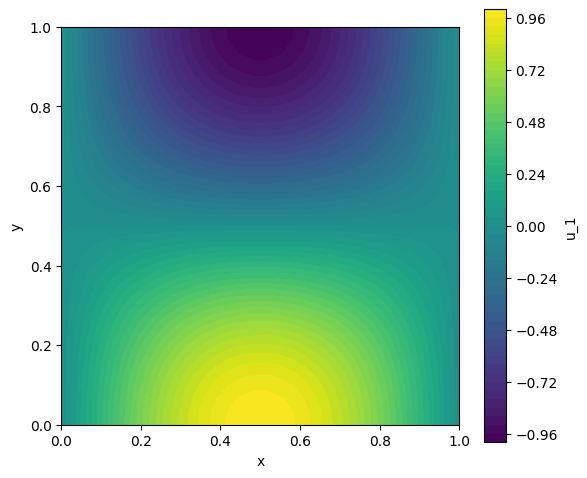

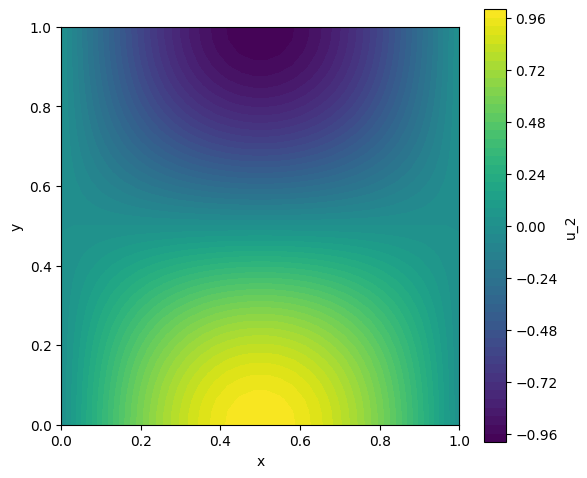

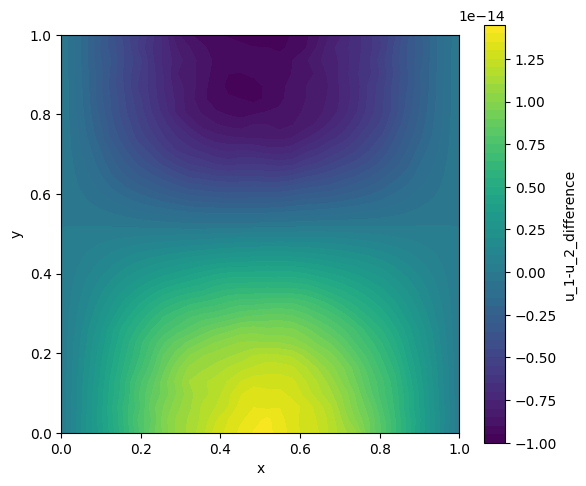

In [3]:
my_contour_plot(nx, ny, u_1, 'u_1')
my_contour_plot(nx, ny, u_2, 'u_2')
u_diff = Function(V, name='u_1_minus_u_2').interpolate(u_1 - u_2)
my_contour_plot(nx, ny, u_diff, 'u_1-u_2_difference')

Note: u_difference of u_1 and u_2 has an error of at most 1.25 * 10^-14. Which is obvious from L2 norm between the two results: 6.159061832043177e-15. Given that the accuracy of floating point arithmetic is 10^-16 if double precision is used, it does not matter which result u_1 or u_2 is being used! 

In [4]:
u_exact = Function(V, name='u_exact').interpolate(sin(pi*x)*cos(pi*y))
u_diff_e = Function(V, name='u_1_minus_u_exact').interpolate(u_1 - u_exact)

Saved contour plot to: u_exact_contour.png
Saved contour plot to: u_1-u_exact_difference_contour.png


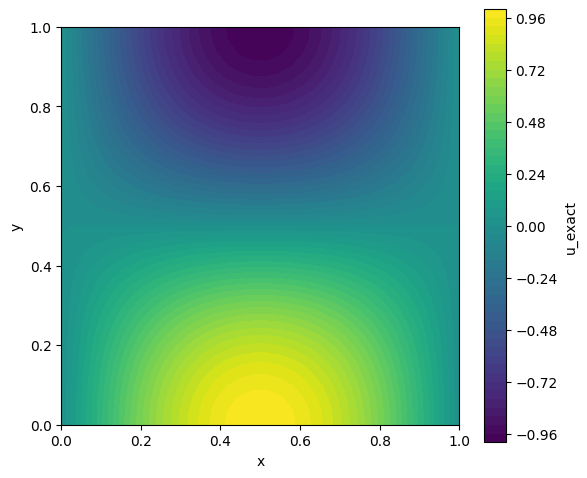

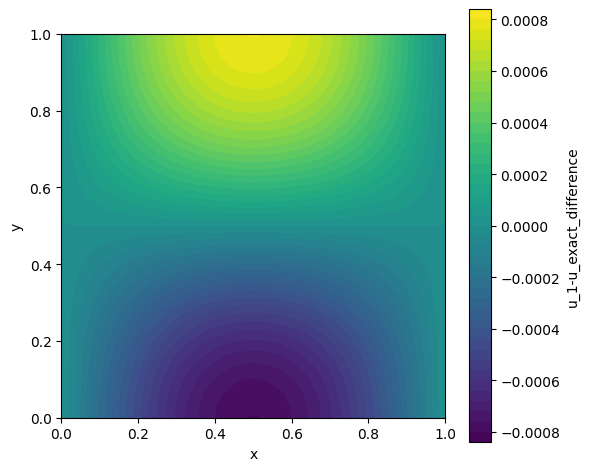

In [5]:
my_contour_plot(nx, ny, u_exact, 'u_exact')
my_contour_plot(nx, ny, u_diff_e, 'u_1-u_exact_difference')

The function spaces used are:
$$
L^2 (\Omega) = \{ u: \Omega \to \mathbb{R}\; | \int_\Omega |u|^2 \; d\Omega < \infty \}
$$
space of $L^2$-integrable functions over the domain $\Omega$. 

The Hilbert space over $\Omega$ that sattisfies boundary conditions and contains solutions of the continuous problem: 
$$
H^1_0 (\Omega) = \{ u \in L^2 \;|\; \partial_x y, \partial_y u \in L^2 (\Omega) \;\& \;u|_{\Gamma_2} = 0 \}.
$$
Lastly, the space of linear functions used for approximating the solution
$$
V_h = \{ u \in H^1_0 \; | \; u = a x + by + c \text{ where } a,b,c \in \mathbb{R}, \; (x,y)\in\Omega \}.
$$
The $V_h \subset H^1_0 (\Omega)$ and in the exercise sheet 1 it is the space of quadratic functions instead. As such in the above code the order of accuracy is 1 and in the exercise sheet it is 2.

Note: continuity is enforced separately from the space $V_h$ when the integrals are being constructed.

### 2. Exploring {h,p} pairs

In the code below we focus on comparing different pairs, $\{ h,p \}$, of mesh refinements, h, and order of accuracy p.

In [6]:
nxs = [4*2**i for i in range(0,8)]  # Mesh resolutions to try: 16,32,64,128,256, 512
print(nxs)
orders = [1,2,3,4] # Polynomial orders to try

results = {}
for nx in nxs:
    ny = nx
    h=1/nx
    mesh = UnitSquareMesh(nx,ny,quadrilateral=True)
    # Quadrilateral regular mesh made: https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.UnitSquareMesh
    x, y = SpatialCoordinate(mesh) # Mesh coordinates

    for p in orders:
        pair = (h, p)
        V = FunctionSpace(mesh, 'CG', p) # Piecewise continuous Galerkin function space of polynomials


        f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y)) # The given function f(x,y)


        bc_x0 = DirichletBC(V, Constant(0), 1) # Dirichlet boundary conditions imposed 
        bc_x1 = DirichletBC(V, Constant(0), 2) # Dirichlet boundary conditions imposed 

        # Defining functions
        v = TestFunction(V)
        u_h = Function(V, name='u_h') # Name of solution for first method
        u_exact = Function(V, name='u_exact').interpolate(sin(pi*x)*cos(pi*y))

        Ju = (0.5*inner(grad(u_h),grad(u_h)) - u_h*f)*dx # f->ULF? Step 2

        F = derivative(Ju, u_h, du=v) # Step 2/3: The weak form generated

        solve(F == 0, u_h, bcs=[bc_x0, bc_x1]) # Step 4: the solution assigned to u2

        f.interpolate(sin(pi*x)*cos(pi*y))
        #L2_h = sqrt(assemble(dot(u_h - f, u_h - f) * dx)) # L2 error solution u1
        L2 = sqrt(assemble(dot(u_h - u_exact, u_h - u_exact) * dx)) # L2 error difference
        results[pair] = {"L2_diff": L2}
print(results)


[4, 8, 16, 32, 64, 128, 256, 512]
{(0.25, 1): {'L2_diff': 0.0224595527532744}, (0.25, 2): {'L2_diff': 0.0002581266490531602}, (0.25, 3): {'L2_diff': 3.3026055722837436e-06}, (0.25, 4): {'L2_diff': 1.0780289692193855e-07}, (0.125, 1): {'L2_diff': 0.006213900940246078}, (0.125, 2): {'L2_diff': 1.6573873959018296e-05}, (0.125, 3): {'L2_diff': 1.0702295304430984e-07}, (0.125, 4): {'L2_diff': 1.7018159698815217e-09}, (0.0625, 1): {'L2_diff': 0.0015930107731052336}, (0.0625, 2): {'L2_diff': 1.0427252512841122e-06}, (0.0625, 3): {'L2_diff': 3.3787660909160757e-09}, (0.0625, 4): {'L2_diff': 2.6666290965120015e-11}, (0.03125, 1): {'L2_diff': 0.0004007573364780158}, (0.03125, 2): {'L2_diff': 6.527728863221749e-08}, (0.03125, 3): {'L2_diff': 1.0585764821639784e-10}, (0.03125, 4): {'L2_diff': 4.458866878207716e-13}, (0.015625, 1): {'L2_diff': 0.0001003464040510207}, (0.015625, 2): {'L2_diff': 4.081519133427896e-09}, (0.015625, 3): {'L2_diff': 3.340280659409523e-12}, (0.015625, 4): {'L2_diff': 7.35

Saved convergence plot to convergence_L2_vs_h.png


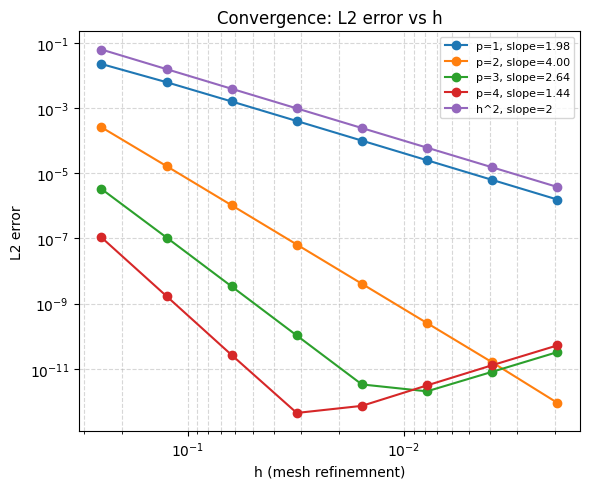

In [7]:
orders_present = sorted({pair[1] for pair in results.keys()})

plt.figure(figsize=(6,5))
for p in orders_present:
    # collect (h, L2) for this order
    items = [(pair[0], results[pair]["L2_diff"]) for pair in results.keys() if pair[1] == p]
    if not items:
        continue
    items_sorted = sorted(items, key=lambda it: it[0])  # sort by h
    hs = np.array([it[0] for it in items_sorted])
    L2s = np.array([float(it[1]) for it in items_sorted], dtype=float)

    # Fit slope in log-log: log(L2) = slope * log(h) + C 
    with np.errstate(divide='ignore', invalid='ignore'):
        coeffs = np.polyfit(np.log(hs), np.log(L2s), 1)
    slope = coeffs[0] if np.isfinite(coeffs).all() else np.nan

    plt.loglog(hs, L2s, '-o', label=f'p={p}, slope={slope:.2f}')

plt.loglog(hs, hs*hs, '-o', label='h^2, slope=2')
plt.gca().invert_xaxis()
plt.xlabel('h (mesh refinemnent)')
plt.ylabel('L2 error')
plt.title('Convergence: L2 error vs h')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('convergence_L2_vs_h.png', dpi=150)
print("Saved convergence plot to convergence_L2_vs_h.png")

The Figure above depicts a relationship between L2 error and mesh size h for different mesh sizes in log-log space. The mesh sizes are: 4, 8, 16, 32, 64, 128, 256 divisions on x and y axis. these correspond to 4^2, 16^2, .... , 256^2 mesh elements.

Observations:
- for $p\in\{ 1,2 \}$ the lines have a constant slope, i.e. error decreases with mesh refinement.
- for $p \in \{ 3, 4\}$ the error decreases initially, but then it starts increasing again.
    - This is because $L_2$ error $= \text{discretization error} (h) + \text{algebraic error} (p)$
    - while discretization error decreases with decreasing h (until the machine precision $10^{-16}$ is achieved), algebraic error is related to adding floating points on computers. In general, for two floats $f_1, f_2$: $(f_1 + f_2)_{\text{on machine}} \neq (f_2 + f_1)_{\text{mathematically}}$. As the order $p$ of the basis functions of $V_h$ increases, there are more terms added inside of each element and so the algebraic error and the overall L^2 error go up.
    - For more refined meshes there are more algebraic operations performed and the increase in algebraic error grows faster than decrease in discretization error (provided it has not reached machine accuracy, in which case it stays constant).
- The above discussion is important to elucidate that the theoretical equivalence is not equal to practical equivalence due to algebraic error!!!!!

- Equivalent $\{ h, p \}$ pairs
    - For $\{ h,1\}$, halving h results in halving L^2 error. As the basis functions are linear and their error is linear $O(h)$.
        - Similarly for $\{h,2\}$ L^2 error is of order $O(h^2)$, 
        - $\{h,3\}$ L^2 error is of order $O(h^3)$, 
        - $\{h,4\}$ L^2 error is of order $O(h^4)$
    - Consider $\{ h_1,1\}$, $\{ h_2,2\}$ such that their L^2 errors are approximately similar:
    $$
    L^2 (\{ h_1,1\}) = O(h_1) = O(h_2^2) = L^2 (\{ h_2,2\}).
    $$
     Then $$L^2 (\{ h_1  2^{-2},1\}) = O(h_1 * 2^{-2}) = O(h_1)$$ we also have that $$L^2 (\{ h_2  2^{-1},2\}) = O((h_2 * 2^{-1})^{2}) = O((h_2^2 * 2^{-2}) = O(h_2^2).$$
     Hence, the $h_1$ must be halved twice to achieve the same effect as halving $h_2$ once.

The above argument can be generalized: 
- Consider $\{ h_p,p\}$, $\{ h_q,q\}$ such that their L^2 errors are approximately similar and $p<q$:
$$
L^2 (\{ h_p,p\}) = O(h_p^p) = O(h_q^q) = L^2 (\{ h_q,q\}).
$$
Then $$L^2 (\{ h_p  2^{-a},p\}) = O(h_p^p * 2^{-ap}) = O(h_p^p)$$ we also have that $$L^2 (\{ h_q  2^{-1},q\}) = O((h_q * 2^{-1})^{q}) = O((h_q^q * 2^{-q}) = O(h_2^q).$$
Hence, the $h_p$ must be halved $a=q/p$ times to achieve the same effect as halving $h_q$ once.

Hence, these are the equivelent pairs:

- $\{h_1,1\}$ and $\{h_2,2\}$ and $\{h_4,4\}$
    - $O(h_1 2^{-4}) = O((h_2 2^{-2})^2) = O((h_4 2^{-1})^{4})$
    - halving $h_4$ once requires halving $h_2$ twice and $h_1$ four times.

### 3. Comments on the code

In [8]:
nxs = [4*2**i for i in range(0,8)]  # Set of all possible number of element divisions
orders = [1,2,3,4] # Polynomial orders to try

results = {} # Dictionary to store results
for nx in nxs:
    ny = nx
    h=1/nx

    mesh = UnitSquareMesh(nx,ny,quadrilateral=True) # Define mesh with quadrilateral elements ONLY!
    
    x, y = SpatialCoordinate(mesh) # Mesh coordinates

    for p in orders:
        pair = (h, p)

        # Defining a function space, a subspace of the full Hilbert space
        # It contains functions that are piecewise polynomials of degree p and continuous from element to element
        V = FunctionSpace(mesh, 'CG', p)


        f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y)) # The given function f(x,y)


        bc_x0 = DirichletBC(V, Constant(0), 1) # Dirichlet boundary conditions imposed 
        bc_x1 = DirichletBC(V, Constant(0), 2) # Dirichlet boundary conditions imposed 

        # Defining functions

        v = TestFunction(V) # Test function from space V, in particular these are piecewise polynomials of degree p - in terms of the basis functions
        u_h = Function(V, name='u_h') # FEM solution function
        u_exact = Function(V, name='u_exact').interpolate(sin(pi*x)*cos(pi*y)) # Exact solution function

        # Weak Formulation
        Ju = (0.5*inner(grad(u_h),grad(u_h)) - u_h*f)*dx # This is the Lagrangian of the Poisson system

        F = derivative(Ju, u_h, du=v) # Applying the principle of least action to get the weak form

        solve(F == 0, u_h, bcs=[bc_x0, bc_x1]) # Solving the weak form to get the FEM solution and enforcing BCs

        f.interpolate(sin(pi*x)*cos(pi*y))

        L2 = sqrt(assemble(dot(u_h - u_exact, u_h - u_exact) * dx)) # L2 error difference of exact an FEM solution
        results[pair] = {"L2_diff": L2}

### 4. Different f(x,y)

Take the following system

$$
-\nabla^2 u = \pi^2 \sin(\pi x) + \pi^2 \cos(\pi y), \;\;\; \text{for } (x,y) \in [ 0,1]^2 \\
u(0,y) = u(1,y) = \partial_y u(x,0) = \partial_x u(x,1) = 0
$$

The exact solution is
$$
u_e = \sin(\pi x) + \cos (\pi y) 
$$

Note: I varified that the above is the solution, yet it does not seem to match the numerical solution. Refining mesh does not make a corresponding change in L2-error. In fact the error is similar for 128 and 64 for nx and ny.

L2 norm between the two results: 0.43090280360956285


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Saved contour plot to: u_h_contour.png
Saved contour plot to: u_exact_contour.png
Saved contour plot to: u_1-u_exact_difference_contour.png


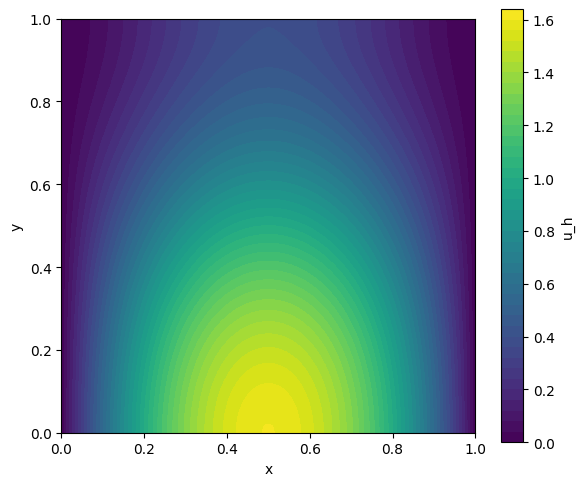

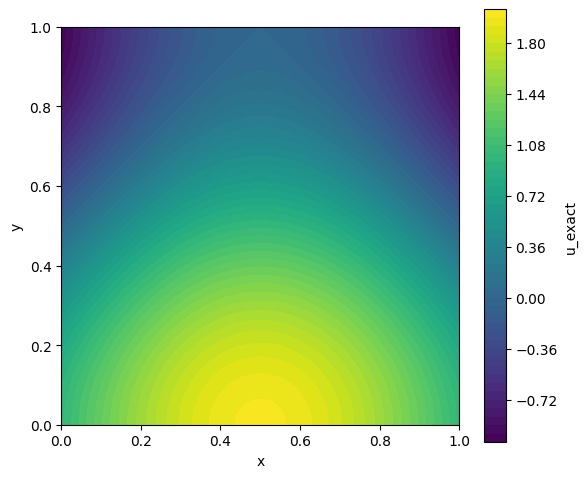

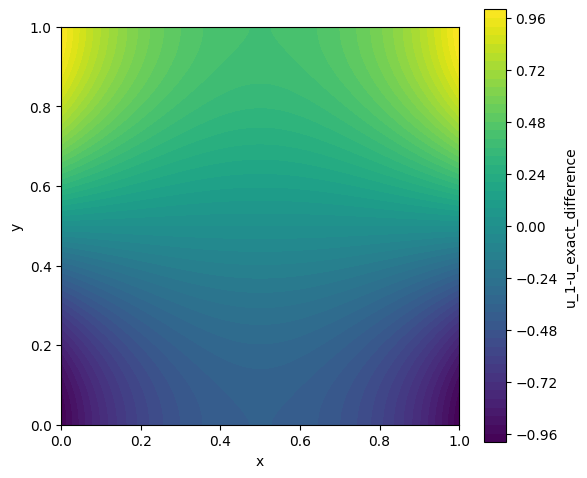

In [21]:

ny = nx = 128

mesh = UnitSquareMesh(nx,ny,quadrilateral=True) # Define mesh with quadrilateral elements ONLY!

x, y = SpatialCoordinate(mesh) # Mesh coordinates

# Defining a function space, a subspace of the full Hilbert space
# It contains functions that are piecewise polynomials of degree p and continuous from element to element
V = FunctionSpace(mesh, 'CG', 2)


f = Function(V).interpolate(pi**2*(sin(pi*x)+cos(pi*y))) # The given function f(x,y)


bc_x0 = DirichletBC(V, Constant(0), 1) # Dirichlet boundary conditions imposed 
bc_x1 = DirichletBC(V, Constant(0), 2) # Dirichlet boundary conditions imposed 

# Defining functions

v = TestFunction(V) # Test function from space V, in particular these are piecewise polynomials of degree p - in terms of the basis functions
u_h = Function(V, name='u_h') # FEM solution function
u_exact = Function(V, name='u_exact').interpolate(sin(pi*x)+cos(pi*y)) # Exact solution function

# Weak Formulation
Ju = (0.5*inner(grad(u_h),grad(u_h)) - u_h*f)*dx # This is the Lagrangian of the Poisson system

F = derivative(Ju, u_h, du=v) # Applying the principle of least action to get the weak form

solve(F == 0, u_h, bcs=[bc_x0, bc_x1]) # Solving the weak form to get the FEM solution and enforcing BCs

#f.interpolate(sin(pi*x)+cos(pi*y))

L2 = sqrt(assemble(dot(u_h - u_exact, u_h - u_exact) * dx)) # L2 error difference of exact an FEM solution
print(f'L2 norm between the two results: {L2}')

u_diff_e = Function(V, name='u_1_minus_u_exact').interpolate(u_h - u_exact)
my_contour_plot(nx, ny, u_h, 'u_h')
my_contour_plot(nx, ny, u_exact, 'u_exact')
my_contour_plot(nx, ny, u_diff_e, 'u_1-u_exact_difference')